## Calculate features from ICs

- Edge fraction
- High frequency content
- ...
- (features from paper)

In [123]:
import os
import sys
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
from nilearn.image import load_img, threshold_img, math_img, resample_to_img
from scipy.ndimage.morphology import binary_erosion
from scipy.signal import periodogram
from os.path import join, pardir
sys.path.append(pardir)
from bids import BIDSLayout
from tqdm import tqdm

In [108]:
# Helper function
def get_comps(metainfo_dict): # runinfo = bids layout?? think it's only needed to retrieve files
    """
    ...
    """
    # retrieve files
    mixmat = np.loadtxt(join(metainfo_dict['fullpath'], 'melodic_mix'))
    ica_nii_f = join(metainfo_dict['fullpath'], 'melodic_IC.nii.gz')
    comps_arr = load_img(ica_nii_f).get_fdata()
    return mixmat, comps_arr

# Helper function
def get_edge_mask(metainfo_dict, ds_layout): # runinfo = bids layout?? think it's only needed to retrieve files
    """
    ...
    """
    # retrieve files
    brainmask_f_temp = ds_layout.get(scope='derivatives',
                                return_type='filename',
                                subject=metainfo_dict['subject'],
                                session=metainfo_dict['session'],
                                run=metainfo_dict['run'],
                                task=metainfo_dict['task'],
                                space=metainfo_dict['space'],
                                desc='brain',
                                suffix='mask',
                                extension='nii.gz')
    brainmask_f = brainmask_f_temp[0]
    # Not sure if I have correct file here, file from Oli's script is:
    # 'fmriprep/../sub-XX_acq-prescannormalized_rec-pydeface_label-CSF_probseg.nii.gz'
    if metainfo_dict['space'] == 'T1w':
        csf_anat_f_temp = ds_layout.get(
                #scope='fmriprep', -> seems not to work, don't know why
                return_type='filename',
                subject=metainfo_dict['subject'],
                #space=metainfo_dict['space'],
                label='CSF',
                suffix='probseg',
                extension='nii.gz')
        csf_anat_f = csf_anat_f_temp[0]
    else:
        csf_anat_f_temp = ds_layout.get(
                #scope='fmriprep', -> seems not to work, don't know why
                return_type='filename',
                subject=metainfo_dict['subject'],
                space=metainfo_dict['space'], # T1w seems not defined
                label='CSF',
                suffix='probseg',
                extension='nii.gz')
        csf_anat_f = csf_anat_f_temp[0]
    csf_func = threshold_img(
        resample_to_img(csf_anat_f, brainmask_f, interpolation='linear'),
        threshold=1.
    )
    brainmask = load_img(brainmask_f).get_fdata()
    mask_img = math_img('img1 - img2', img1=brainmask_f, img2=csf_func)
    mask_arr = mask_img.get_fdata()
    # worked okayish with erosion iterations=2
    # -> what is erosion?
    edgefrac_thickness = int(2)
    ero_mask = binary_erosion(mask_arr, iterations=edgefrac_thickness).astype(int)
    edgemask = mask_arr - ero_mask
    return edgemask.astype(bool), brainmask.astype(bool)

# Edge fraction
def calc_edgefrac(comp_arr, edgemask, brainmask):
    return np.absolute(comp_arr[edgemask]).sum() / np.absolute(comp_arr[brainmask]).sum()

# High frequency content
def calc_hfc(timeseries, tr=1.5):
    """Calculate high frequency content for time series data. Tr can generally mean sampling rate in seconds."""
    nf = (1. / tr) * .5  # nyquist
    freqs, power = periodogram(timeseries, fs=1. / tr)
    relcumsum = np.cumsum(power) / power.sum()
    freqind = np.argmin(np.absolute(relcumsum - .5))
    hfc = freqs[freqind] / nf
    return hfc

In [5]:
# Hardcoded paths
bidsdata_dir = '/LOCAL/jzerbe/faces_vs_houses/ds002938'
base_dir = '/LOCAL/jzerbe/temp_results'
melodic_base_dir = join(bidsdata_dir, 'derivatives', 'melodic')

In [118]:
# Main: Get dict with calculated features for each melodic run
ds_layout = BIDSLayout(bidsdata_dir, derivatives=True)
melodic_entities = ds_layout.get(scope='melodic', return_type='filename', suffix='IC', extension='nii.gz')
results_dicts = []
for entity in tqdm(melodic_entities, desc='iterating over runs'):
    # Cumbersome workaround to get correct filenames (TODO: better filenaming!)
    melodic_dir_split = entity.split('/')
    dir_name = melodic_dir_split[-2]
    metainfo_split = dir_name.split('_')
    metainfo_dict = {'subject':(metainfo_split[0])[4:], 'session':(metainfo_split[1])[4:],
                     'task':(metainfo_split[2])[5:], 'run':(metainfo_split[3])[4:],
                     'space':(metainfo_split[4])[6:-8], 'directory':melodic_dir_split[-2],
                     'fullpath':'/'.join(melodic_dir_split[:-1])}
    metainfo_dict['session'] = None if metainfo_dict['session'] == 'None' else metainfo_dict['session']
    metainfo_dict['run'] = None if metainfo_dict['run'] == 'None' else metainfo_dict['run']
    
    mixmat, comps_arr = get_comps(metainfo_dict)
    edgemask, brainmask = get_edge_mask(metainfo_dict, ds_layout)
    for comp_i in range(mixmat.shape[-1]):
        results_dict = {'subject': metainfo_dict['subject'], 'session': metainfo_dict['session'], 'task': metainfo_dict['task'],
                                'run': metainfo_dict['run']}
        comp_arr = comps_arr[:, :, :, comp_i]
        comp_ts = mixmat[:, comp_i]
        # Calculate edge fraction
        results_dict['edgefrac'] = calc_edgefrac(comp_arr, edgemask, brainmask)
        # Calculate high frequency content
        results_dict['hfc'] = calc_hfc(comp_ts)
        results_dicts.append(results_dict)
    

iterating over runs: 100%|██████████| 36/36 [02:13<00:00,  3.70s/it]


In [119]:
# Put results in dataframe
results_df = pd.DataFrame(results_dicts)
results_df

,subject,session,task,run,edgefrac,hfc
0,03,None,1back,None,0.421213,0.028070
1,03,None,1back,None,0.389955,0.014035
2,03,None,1back,None,0.359809,0.407018
3,03,None,1back,None,0.294835,0.056140
4,03,None,1back,None,0.359666,0.392982
...,...,...,...,...,...,...
2866,28,None,effort,None,0.482698,0.363636
2867,28,None,effort,None,0.419955,0.276180
2868,28,None,effort,None,0.473835,0.313003
2869,28,None,effort,None,0.511086,0.287687


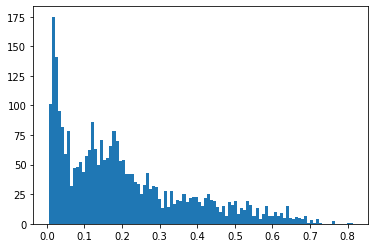

In [138]:
# Visualize hfc
#hfc_plt = results_df['hfc'].hist(bins=100)
hfc_plt = plt.hist(results_df['hfc'], bins=100)
plt.savefig('hfc_ds002938.jpg')

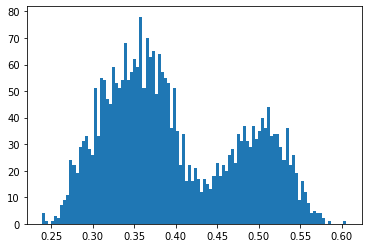

In [139]:
# Visualize edge fraction
edgefrac_plt = plt.hist(results_df['edgefrac'], bins=100)
plt.savefig('edgefrac_ds002938.jpg')